In [51]:
from pint.logging import setup as setup_log

from enterprise.pulsar import Pulsar
from enterprise.signals.signal_base import PTA
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import MarginalizingTimingModel
from enterprise_extensions.blocks import red_noise_block, dm_noise_block

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt

from copy import deepcopy

In [8]:
setup_log(level="WARNING")

1

In [9]:
psr = Pulsar("sim5.fit.par", "sim5.tim", timing_package="pint")

In [10]:
tm = MarginalizingTimingModel()
wn = MeasurementNoise(efac=1)
rn = red_noise_block(components=7)
dmn = dm_noise_block(components=5)

In [11]:
signal = tm + wn + dmn + rn

In [12]:
pta = PTA([signal(psr)])

In [13]:
pta.param_names

['SIM3_dm_gp_gamma',
 'SIM3_dm_gp_log10_A',
 'SIM3_red_noise_gamma',
 'SIM3_red_noise_log10_A']

In [14]:
ndim = len(pta.param_names)
x0 = np.array(
    [4, -13.5, 3.5, -13.0]
    # [p.sample() for p in pta.params]
)
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/"
Niter = 200000

In [15]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [16]:
sampler.sample(
    x0,
    Niter,
)

Finished 0.00 percent in 0.000537 s Acceptance rate = 0

Finished 5.00 percent in 2.456726 s Acceptance rate = 0.594656Adding DE jump with weight 20
Finished 100.00 percent in 46.443263 s Acceptance rate = 0.47677
Run Complete


WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


In [17]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
# burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

In [54]:
gamma_dm, log10_A_dm, gamma_red, log10_A_red = np.median(burned_chain, axis=0)

In [40]:
from pint.models import get_model_and_toas, get_model
from pint.utils import pldmnoise_from_dmwavex, plrednoise_from_wavex
from pint import DMconst
from astropy import units as u

In [73]:
m, t = get_model_and_toas("sim5.wx.par", "sim5.tim")

In [74]:
m_pint = plrednoise_from_wavex(pldmnoise_from_dmwavex(m))

In [75]:
scale = DMconst / (1400 * u.MHz)**2

idxs = np.array(m.components["DMWaveX"].get_indices())
ad = np.array([(scale*m[f"DMWXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dad = np.array([(scale*m[f"DMWXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
bd = np.array([(scale*m[f"DMWXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dbd = np.array([(scale*m[f"DMWXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
fd = np.array([(m[f"DMWXFREQ_{idx:04d}"].quantity).to_value("1/year") for idx in idxs])

Pd = (ad**2 + bd**2) / 2
dPd = ((ad*dad)**2 + (bd*dbd)**2)**0.5

In [76]:
m_inj = get_model("sim5.par")
m_ent = deepcopy(m_inj)
m_ent.TNREDAMP = log10_A_red
m_ent.TNREDGAM = gamma_red
m_ent.TNDMAMP = log10_A_dm
m_ent.TNDMGAM = gamma_dm

In [77]:
Pd_pint = m_pint.components["PLDMNoise"].get_noise_weights(t)[::2]
Pd_inj = m_inj.components["PLDMNoise"].get_noise_weights(t)[::2][:5]
Pd_ent = m_ent.components["PLDMNoise"].get_noise_weights(t)[::2][:5]

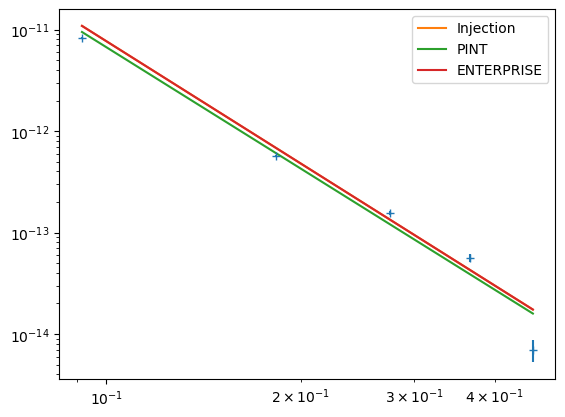

In [78]:
plt.errorbar(fd, Pd, dPd, ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

plt.plot(fd, Pd_inj, label="Injection")
plt.plot(fd, Pd_pint, label="PINT")
plt.plot(fd, Pd_ent, label="ENTERPRISE")

plt.legend()

In [79]:
scale = 1
idxs = np.array(m.components["WaveX"].get_indices())
ar = np.array([(scale*m[f"WXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dar = np.array([(scale*m[f"WXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
br = np.array([(scale*m[f"WXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dbr = np.array([(scale*m[f"WXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
fr = np.array([(m[f"WXFREQ_{idx:04d}"].quantity).to_value("1/year") for idx in idxs])

Pr = (ar**2 + br**2) / 2
dPr = ((ar*dar)**2 + (br*dbr)**2)**0.5

Pr_pint = m_pint.components["PLRedNoise"].get_noise_weights(t)[::2]
Pr_inj = m_inj.components["PLRedNoise"].get_noise_weights(t)[::2][:7]
Pr_ent = m_ent.components["PLRedNoise"].get_noise_weights(t)[::2][:7]

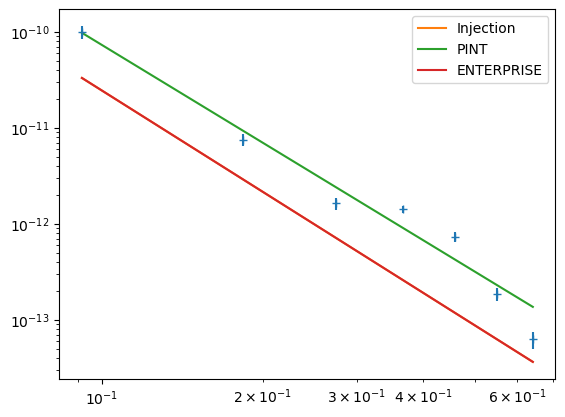

In [82]:
plt.errorbar(fr, Pr, dPr, ls="", marker="+")
plt.xscale("log")
plt.yscale("log")

plt.plot(fr, Pr_inj, label="Injection")
plt.plot(fr, Pr_pint, label="PINT")
plt.plot(fr, Pr_ent, label="ENTERPRISE")
plt.legend()

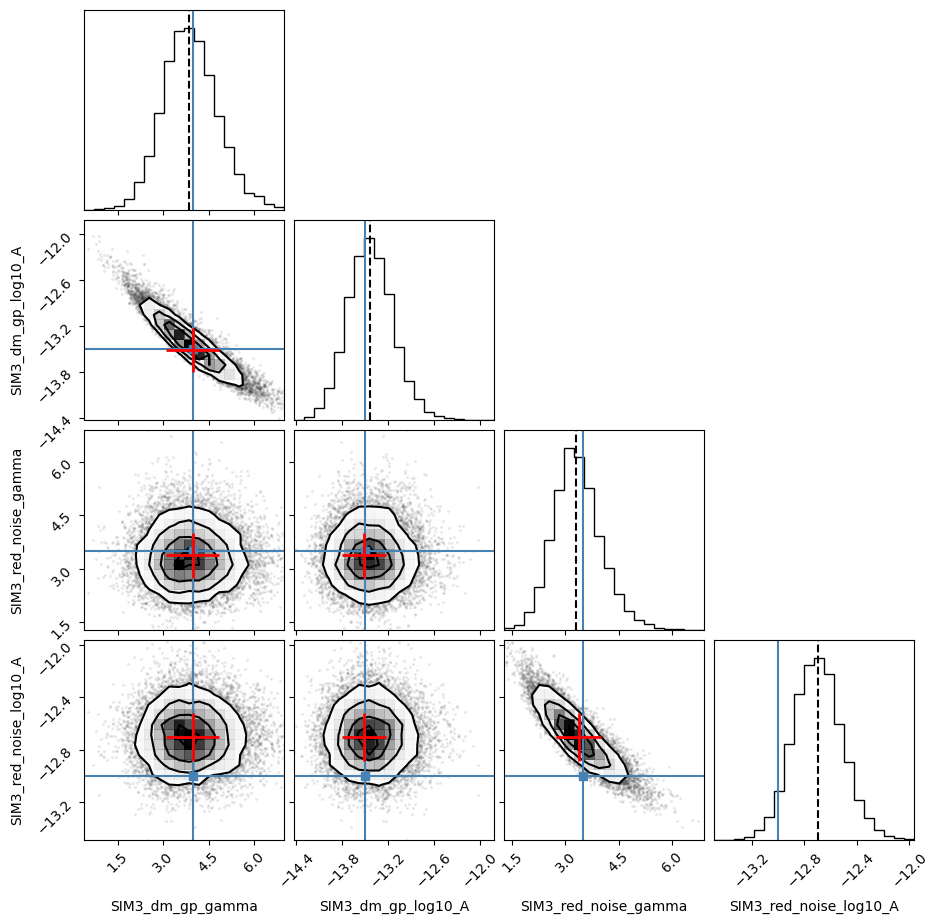

In [84]:
true_params = [
    m_inj.TNDMGAM.value, 
    m_inj.TNDMAMP.value, 
    m_inj.TNREDGAM.value, 
    m_inj.TNREDAMP.value
]

fig = corner.corner(
    burned_chain, 
    labels=pta.param_names, 
    truths=[4, -13.5, 3.5, -13.0],
    quantiles=[0.5]
)

pint_params = [
    m_pint.TNDMGAM.value, 
    m_pint.TNDMAMP.value, 
    m_pint.TNREDGAM.value, 
    m_pint.TNREDAMP.value
]

pint_errors = [
    m_pint.TNDMGAM.uncertainty_value, 
    m_pint.TNDMAMP.uncertainty_value, 
    m_pint.TNREDGAM.uncertainty_value, 
    m_pint.TNREDAMP.uncertainty_value
]

for i in range(ndim):
    x = pint_params[i]
    dx = pint_errors[i]
    for j in range(i+1, ndim):
        y = pint_params[j]
        dy = pint_errors[j]
        
        try:
            plt.subplot(ndim, ndim, i + ndim*j + 1)
            plt.errorbar(x=[x], y=[y], xerr=[dx], yerr=[dy], color="red", elinewidth=2)

            # plt.tick_params(labelsize=19)
        except:
            print(i, j, )

In [67]:
true_params

[4.0, -13.5, 3.5, -13.0]

In [68]:
pint_params

[3.970341976583563,
 -13.514749978162524,
 3.378323112319773,
 -12.701817203529187]

In [71]:
np.median(burned_chain, axis=0)

array([  3.86700966, -13.43385495,   3.29409246, -12.69905282])